In [3]:
#导包
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

data = pd.read_csv('/home/aistudio/train.csv')  # 导入数据
data['subscribe'] = data['subscribe'].map({"no":0, "yes":1}) #把yes，no变成1,0

In [4]:
#查看数据概述
data.describe()

,id,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_index,cons_conf_index,lending_rate3m,nr_employed,subscribe
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000
mean,11250.500000,40.407511,1146.303733,3.364800,773.991956,1.316444,0.078529,93.548785,-39.877180,3.302490,5137.211285,0.131200
std,6495.334864,12.086078,1432.432125,7.223837,326.934334,1.918733,1.573831,2.805786,5.805442,1.611777,170.670611,0.337626
min,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,-3.400000,87.640000,-53.280000,0.600000,4715.420000,0.000000
25%,5625.750000,32.000000,143.000000,1.000000,557.750000,0.000000,-1.800000,91.190000,-44.160000,1.430000,5008.510000,0.000000
50%,11250.500000,38.000000,353.000000,1.000000,964.000000,0.000000,1.100000,93.540000,-40.600000,3.920000,5133.955000,0.000000
75%,16875.250000,47.000000,1873.000000,3.000000,1005.000000,2.000000,1.400000,95.920000,-35.797500,4.830000,5267.677500,0.000000
max,22500.000000,101.000000,5149.000000,57.000000,1048.000000,6.000000,1.400000,99.460000,-25.550000,5.270000,5489.500000,1.000000


In [5]:
#查看数据缺失率
data.shape
data_s = data.select_dtypes(include=['object'])

for i in range(len(data_s.columns)):
    u = sum(data_s.iloc[:,i] == 'unknown')
    if u > 0:
        print(data_s.columns[i],'缺失率:%.2f%%'%(100*u/36169))
    else:
        pass


job 缺失率:0.76%
marital 缺失率:0.88%
education 缺失率:2.75%
default 缺失率:13.44%
housing 缺失率:2.45%
loan 缺失率:2.46%


In [10]:
#查看subscribe的情况
data.subscribe.value_counts()

0    19548
1     2952
Name: subscribe, dtype: int64

In [6]:
#独热编码
data_df = data.drop(['id'], axis=1)
data_dummy = pd.get_dummies(data_df.select_dtypes(include=['object']))
data_oh = pd.concat([data_dummy, data_df.select_dtypes(exclude=['object'])], axis=1)



age                   int64
job                  object
marital              object
education            object
default              object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome             object
emp_var_rate        float64
cons_price_index    float64
cons_conf_index     float64
lending_rate3m      float64
nr_employed         float64
subscribe             int64
dtype: object
object     10
int64       6
float64     5
dtype: int64
age                   int64
job                  object
marital              object
education            object
default              object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
duration              int64
campaign              int64
pdays  

In [8]:
data_oh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   job_admin.                     22500 non-null  uint8  
 1   job_blue-collar                22500 non-null  uint8  
 2   job_entrepreneur               22500 non-null  uint8  
 3   job_housemaid                  22500 non-null  uint8  
 4   job_management                 22500 non-null  uint8  
 5   job_retired                    22500 non-null  uint8  
 6   job_self-employed              22500 non-null  uint8  
 7   job_services                   22500 non-null  uint8  
 8   job_student                    22500 non-null  uint8  
 9   job_technician                 22500 non-null  uint8  
 10  job_unemployed                 22500 non-null  uint8  
 11  job_unknown                    22500 non-null  uint8  
 12  marital_divorced               22500 non-null 

In [11]:
# 数据集划分
X = data_oh.drop(['subscribe'], axis=1)   
y = data_oh.subscribe                  
#测试集占训练集30%
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=90)


GBDT(Gradient Boosting Decision Tree)是目前工业和各种竞赛中非常抢手的模型，性能表现出色，特别是XgBoost，LightGBM推出后，模型性能和运行效率进一步提升。GBDT模型是一个集成模型，基分类器采用CART，集成方式为Gradient Boosting。

CART是一个分类回归二叉决策树，构建一棵二叉树，主要涉及到一下一个问题：

怎么分裂一个特征？
怎么选择最佳分裂特征？
确定分裂的停止条件？
决策树的优化：剪枝方法？
因为CART是一棵二叉树，所以在分裂特征时与 ID3、C4.5有区别。
CART在分类时采用最小平方误差来选择最优切分特征和切分点。

Boosting
Boosting是一种模型的组合方式，我们熟悉的AdaBoost就是一种Boosting的组合方式。和随机森林并行训练不同的决策树最后组合所有树的bagging方式不同，Boosting是一种递进的组合方式，每一个新的分类器都在前一个分类器的预测结果上改进，所以说boosting是减少bias而bagging是减少variance的模型组合方式。
下面是GDBT的一个简单例子：判断用户是否会喜欢电脑游戏，特征有年龄，性别和职业。需要注意的是，GBDT无论是用于分类和回归，采用的都是回归树，分类问题最终是将拟合值转换为概率来进行分类的。

![](https://ai-studio-static-online.cdn.bcebos.com/13dd4b65a70a4cf3b3b9b0e0c945c7757cc47534110940f088e6c15004c47b8b)

在上图中,每个用户的最后的拟合值为两棵树的结果相加。

GBDT的主要优点：

　　1）可以灵活的处理各种类型的数据

　　2）预测的准确率高

　　3）使用了一些健壮的损失函数，如huber，可以很好的处理异常值

GBDT的缺点：

　　1）由于基学习器之间的依赖关系，难以并行化处理，不过可以通过子采样的SGBT来实现部分并行。

 

In [13]:
GBDT= GradientBoostingClassifier(random_state=90)
GBDT.fit(Xtrain, ytrain)
GBDT.score(Xtest, ytest)
y_pred= GBDT.predict(Xtest)

print("Accuracy : %.4g" % metrics.accuracy_score(ytest.values, y_pred))
print("f1 Score (Train): %f" % metrics.f1_score(ytest, y_pred))

Accuracy : 0.884
f1 Score (Train): 0.360816


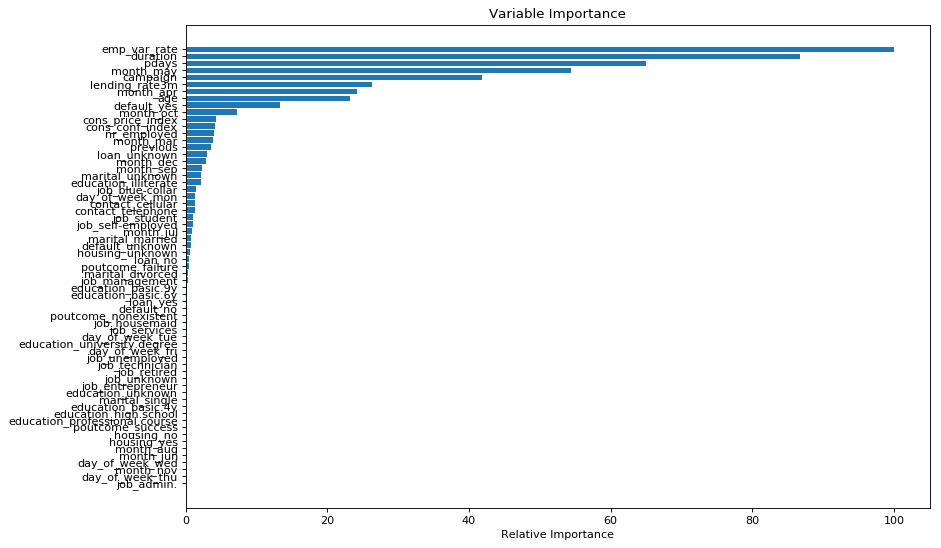

In [14]:
%matplotlib inline
# Plot feature importance
def plot_feature_importance(clf, feature_names):
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(12,8), dpi= 80)
    #plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    # plt.yticks(pos, feature_names[sorted_idx])
    plt.yticks(pos, [feature_names[idx] for idx in sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    #plt.savefig("result/特征重要程度.jpg", dpi=300)  # 保存图片到本地
    plt.show()
    
plot_feature_importance(GBDT, Xtrain.columns)

机器学习中的一大难点就是参数调优，每个模型会有很多可调节的模型参数。
模型参数（Hyperparameters）调优的通用做法是Grid Search或者Random Search，Sklearn中已经提供了相应的方法GridSearchCV和RandomizedSearchCV。 这两种搜索方法都包括Search和CV两步，即搜索和交叉验证。

GridSearch在需要调节参数的指定取值范围，遍历所有组合寻，比如有两个参数，第一个有两种值，第二个有三种，那就会有六种组合。GridSearch会对每种参数组合做一遍交叉验证，记录模型得分，最后找到得分最好的那个参数组合。GridSearchCV可以保证在指定的参数范围内找到精度最高的参数，但它要求遍历所有可能参数的组合，在面对大数据集和多参数的情况下会非常耗时。

RandomizedSearchCV的使用方法其实是和GridSearchCV一致的，但它以随机在参数空间中采样的方式代替了GridSearchCV对于参数的网格搜索，在对于有连续变量的参数时，RandomizedSearchCV会将其当作一个分布进行采样，它的搜索能力取决于设定的循环n_iter参数。

In [15]:
# 网格寻参,寻找最优'max_depth'、'min_samples_split'；耗时费力，数据集大的时候不好用

param_grid = {'max_depth':np.arange(10, 20, 5), #决策树最大深度max_depth和内部节点再划分所需最小样本数min_samples_split
              'min_samples_split':np.arange(50, 100, 10)}
print(" param_grid: ", param_grid)

gbdt = GradientBoostingClassifier(random_state=90)
GS = GridSearchCV(gbdt,param_grid,n_jobs=-1,cv=3)
GS.fit(Xtrain,ytrain)
# print('网格搜索-度量记录：',GS.cv_results_)  # 包含每次训练的相关信息
print('网格搜索-最佳度量值:',GS.best_score_)  # 获取最佳度量值
print('网格搜索-最佳参数：',GS.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('网格搜索-最佳模型：',GS.best_estimator_)  # 获取最佳度量时的分类器模型


 param_grid:  {'max_depth': array([10, 15]), 'min_samples_split': array([50, 60, 70, 80, 90])}
网格搜索-最佳度量值: 0.8789206349206348
网格搜索-最佳参数： {'max_depth': 10, 'min_samples_split': 60}
网格搜索-最佳模型： GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=60,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=90, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [16]:
# 随机策略寻参
param_dist = {
    'learning_rate':np.linspace(0.1,2,20), #步长(learning rate)和迭代次数(n_estimators)
    'n_estimators':range(80,200,4),
    'max_depth':range(2,15,1), #决策树最大深度max_depth和内部节点再划分所需最小样本数min_samples_split、叶子节点最少样本数
    'min_samples_split':range(100,801,200),
    'min_samples_leaf':range(60,101,10),
    'max_features':range(7,20,2), #最大特征数max_features
    'subsample':np.linspace(0.7,0.9,20) #子采样的比例
}

gbdt = GradientBoostingClassifier()
RS = RandomizedSearchCV(gbdt,param_dist,cv = 3,scoring = 'accuracy',n_iter=10,n_jobs = -1)

#在训练集上训练
RS.fit(Xtrain, ytrain)
#返回最优的训练器

#print('网格搜索-度量记录：',RS.cv_results_)  # 包含每次训练的相关信息
print('网格搜索-最佳度量值:',RS.best_score_)  # 获取最佳度量值
print('网格搜索-最佳参数：',RS.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('网格搜索-最佳模型：',RS.best_estimator_)  # 获取最佳度量时的分类器模型


网格搜索-最佳度量值: 0.8809523809523809
网格搜索-最佳参数： {'subsample': 0.731578947368421, 'n_estimators': 88, 'min_samples_split': 700, 'min_samples_leaf': 100, 'max_features': 9, 'max_depth': 14, 'learning_rate': 0.1}
网格搜索-最佳模型： GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=14,
                           max_features=9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=700,
                           min_weight_fraction_leaf=0.0, n_estimators=88,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.731578947368421,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [18]:
# 建模
GBDT = RS.best_estimator_
GBDT.fit(Xtrain, ytrain)
GBDT.score(Xtest, ytest)
y_pred= GBDT.predict(Xtest)
y_predprob= GBDT.predict_proba(Xtest)[:,1]
print("Accuracy : %.4g" % metrics.accuracy_score(ytest.values, y_pred))
print("F1 Score (Train): %f" % metrics.f1_score(ytest, y_pred))

Accuracy : 0.8843
F1 Score (Train): 0.428676


In [13]:
# 模型保存与载入
!pip install joblib
import joblib
joblib.dump(GBDT, "/home/aistudio/work/GBDT.model")
GBDT = joblib.load("/home/aistudio/work/GBDT.model")

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [19]:
# 载入测试集，结果输出
data_test = pd.read_csv('/home/aistudio/test.csv')

id = data_test.id
data_test.drop(['id'], axis=1, inplace=True)
data_test_dummy = pd.get_dummies(data_test.select_dtypes(include=['object']))
data_test_oh = pd.concat([data_test_dummy, data_test.select_dtypes(exclude=['object'])], axis=1)
pred = GBDT.predict(data_test_oh)

data_out = pd.DataFrame(pred, index=id, columns=['subscribe'])
data_out['subscribe'] = data_out['subscribe'].map({0:'no', 1:'yes'})
data_out.to_csv('/home/aistudio/work/202031100314.csv')


### 反馈与建议
- 联系人：shangfr
- 邮箱：shangfr@foxmail.com